<a href="https://colab.research.google.com/github/Al-Hasib/computer_vision/blob/master/Gender__detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Gender Classification of Images And Videos Using CNN

In [ ]:
# import the library packages
import tensorflow as tf
from keras import layers
from keras.models import Sequential
import numpy as np
import os
import shutil
import tarfile
import matplotlib.pyplot as plt

Extract Data from Google Drive

In [ ]:
from google.colab import drive 
drive.mount('/content/Dataset')

path = 'Dataset/MyDrive/Dataset/UTKFace.tar.gz'
file = tarfile.open(path)
file.extractall('face')
print('ok')
file.close()

Mounted at /content/Dataset
ok


Separate the images by Male and Female Folder

In [ ]:
path = 'face/UTKFace/'

# Make two folder in the face(root) directory
os.mkdir('face/male')
os.mkdir('face/female')

# divide the images into two folder(male or female)
for i in os.listdir(path):
  if (i.split('_')[1])=='0':
    shutil.move(os.path.join(path,i),'face/male/')
  else:
    shutil.move(os.path.join(path,i),'face/female')

# remove the empty folder
os.rmdir('face/UTKFace')

Transform the data into Batches

In [ ]:
batch_size = 32
img_height = 160
img_width = 160
data_dir = 'face/'

# training data batches
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# validation data batches
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Create test data batches
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))

# Autotune the data
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 23708 files belonging to 2 classes.
Using 18967 files for training.
Found 23708 files belonging to 2 classes.
Using 4741 files for validation.
Number of train batches: 593
Number of test batches: 29
Number of validation batches: 120


Now Train the data for the first time

In [ ]:
model_1 = Sequential([
                      
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(160,160,3)),
    layers.MaxPool2D(2,2),

    layers.Conv2D(64,(5,5),activation='relu'),
    layers.MaxPool2D(3,3),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])

model_1.compile(loss='BinaryCrossentropy',metrics=['accuracy'],optimizer='adam')

model_1.fit(train_ds,validation_data=val_ds,epochs=10)

Epoch 1/10
593/593 [==============================] - 41s 47ms/step - loss: 1.8069 - accuracy: 0.7864 - val_loss: 0.3637 - val_accuracy: 0.8303
Epoch 2/10
593/593 [==============================] - 20s 34ms/step - loss: 0.3295 - accuracy: 0.8520 - val_loss: 0.3113 - val_accuracy: 0.8592
Epoch 3/10
593/593 [==============================] - 19s 33ms/step - loss: 0.3007 - accuracy: 0.8672 - val_loss: 0.3014 - val_accuracy: 0.8699
Epoch 4/10
593/593 [==============================] - 19s 31ms/step - loss: 0.2806 - accuracy: 0.8765 - val_loss: 0.3162 - val_accuracy: 0.8600
Epoch 5/10
593/593 [==============================] - 19s 31ms/step - loss: 0.2716 - accuracy: 0.8806 - val_loss: 0.2965 - val_accuracy: 0.8681
Epoch 6/10
593/593 [==============================] - 19s 31ms/step - loss: 0.2521 - accuracy: 0.8900 - val_loss: 0.3289 - val_accuracy: 0.8613
Epoch 7/10
593/593 [==============================] - 19s 31ms/step - loss: 0.2431 - accuracy: 0.8934 - val_loss: 0.3129 - val_accuracy:

Evaluate the model in the Test Dataset

In [ ]:
losses,accuracy = model_1.evaluate(test_ds,verbose=0)
print(f'losses: {losses} and Accuracy: {accuracy*100}')


losses: 0.3763147294521332 and Accuracy: 84.91379022598267


Almost 85% Accuracy in the test dataset is a good accuracy but want to improve!!!

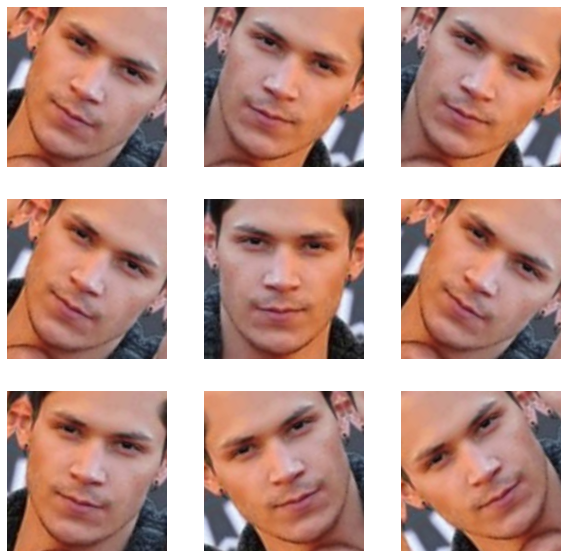

In [ ]:
# Augment the trainint data
data_augmentation = Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
])

for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


Normalize the data (0 to 1)

In [ ]:
train_ds = train_ds.map(lambda x,y:(tf.keras.layers.Rescaling(1.255)(x),y))
test_ds = test_ds.map(lambda x,y:(tf.keras.layers.Rescaling(1.255)(x),y))
val_ds = val_ds.map(lambda x,y:(tf.keras.layers.Rescaling(1.255)(x),y))

Now Train with Augment data and Normalize data and see the performance of the previous model

In [ ]:
model_2 = Sequential([
    data_augmentation,
                      
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPool2D(2,2),

    layers.Conv2D(64,(5,5),activation='relu'),
    layers.MaxPool2D(3,3),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])

model_2.compile(loss='BinaryCrossentropy',metrics=['accuracy'],optimizer='adam')

model_2.fit(train_ds,validation_data=val_ds,epochs=20)

Epoch 1/20
593/593 [==============================] - 24s 38ms/step - loss: 3.8332 - accuracy: 0.5548 - val_loss: 0.6921 - val_accuracy: 0.5788
Epoch 2/20
593/593 [==============================] - 21s 35ms/step - loss: 0.6846 - accuracy: 0.5747 - val_loss: 0.6609 - val_accuracy: 0.6336
Epoch 3/20
593/593 [==============================] - 22s 38ms/step - loss: 0.6872 - accuracy: 0.5606 - val_loss: 0.6816 - val_accuracy: 0.5919
Epoch 4/20
593/593 [==============================] - 21s 35ms/step - loss: 0.6782 - accuracy: 0.5877 - val_loss: 0.6698 - val_accuracy: 0.6045
Epoch 5/20
593/593 [==============================] - 20s 35ms/step - loss: 0.6206 - accuracy: 0.6707 - val_loss: 0.5706 - val_accuracy: 0.7162
Epoch 6/20
593/593 [==============================] - 21s 35ms/step - loss: 0.5271 - accuracy: 0.7451 - val_loss: 0.4917 - val_accuracy: 0.7726
Epoch 7/20
593/593 [==============================] - 21s 35ms/step - loss: 0.5015 - accuracy: 0.7592 - val_loss: 0.4994 - val_accuracy:

In [ ]:
loss , accuracy = model_2.evaluate(test_ds,verbose=0)
print(f'loss : {loss} and accuracy : {accuracy}')


loss : 0.3294900953769684 and accuracy : 0.8459051847457886


Here, loss decrease some but accuracy doesnot improve.. Try to Pretrained Model Like Resnet, MobileNet and Others.

In [ ]:
# Resnet_50

preprocess_input = tf.keras.applications.resnet50.preprocess_input
resnet_50 = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                                    weights='imagenet',
                                                    input_shape=(160,160,3))

resnet_50.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

#feature_batch,label_batch = next(iter(train_ds))
#print(feature_batch.shape)
#feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(1)
#prediction_batch = prediction_layer(feature_batch_average)



inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = resnet_50(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss='BinaryCrossentropy',metrics=['accuracy'],optimizer='adam')

model_3.fit(train_ds,validation_data=val_ds,epochs=20)

Epoch 1/20
593/593 [==============================] - 65s 85ms/step - loss: 3.5230 - accuracy: 0.7126 - val_loss: 2.5272 - val_accuracy: 0.7946
Epoch 2/20
593/593 [==============================] - 46s 78ms/step - loss: 3.5633 - accuracy: 0.7361 - val_loss: 2.4181 - val_accuracy: 0.8201
Epoch 3/20
593/593 [==============================] - 46s 78ms/step - loss: 3.4701 - accuracy: 0.7445 - val_loss: 2.8195 - val_accuracy: 0.7847
Epoch 4/20
593/593 [==============================] - 45s 76ms/step - loss: 3.8095 - accuracy: 0.7265 - val_loss: 7.0940 - val_accuracy: 0.5332
Epoch 5/20
593/593 [==============================] - 45s 77ms/step - loss: 4.6019 - accuracy: 0.6832 - val_loss: 2.5384 - val_accuracy: 0.8169
Epoch 6/20
593/593 [==============================] - 46s 77ms/step - loss: 3.1386 - accuracy: 0.7733 - val_loss: 2.4477 - val_accuracy: 0.8188
Epoch 7/20
593/593 [==============================] - 45s 76ms/step - loss: 3.2403 - accuracy: 0.7665 - val_loss: 3.0118 - val_accuracy:

In [ ]:
loss, acc = model_3.evaluate(test_ds)
print(f'loss : {loss} and accuracy : {acc*100}')

29/29 [==============================] - 2s 67ms/step - loss: 2.5484 - accuracy: 0.8190
loss : 2.548370361328125 and accuracy : 81.8965494632721


Without train any layer of Resnet50, get the accuracy alomost 82%. Now try to train some layer also of resnet50 model and look the performance.

In [ ]:
fine_tune = 100
resnet_50.trainable = True
for layer in resnet_50.layers[:fine_tune]:
  resnet_50.trainable = False
base_learning_rate = 0.0001
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model_3.fit(train_ds,validation_data=val_ds,epochs=5)

Epoch 1/5
593/593 [==============================] - 50s 78ms/step - loss: 0.9937 - accuracy: 0.8007 - val_loss: 0.8892 - val_accuracy: 0.8324
Epoch 2/5
593/593 [==============================] - 46s 77ms/step - loss: 0.9824 - accuracy: 0.7990 - val_loss: 0.8437 - val_accuracy: 0.8374
Epoch 3/5
593/593 [==============================] - 46s 77ms/step - loss: 0.9491 - accuracy: 0.8027 - val_loss: 0.8387 - val_accuracy: 0.8353
Epoch 4/5
593/593 [==============================] - 46s 77ms/step - loss: 0.9234 - accuracy: 0.8011 - val_loss: 0.8259 - val_accuracy: 0.8358
Epoch 5/5
593/593 [==============================] - 46s 77ms/step - loss: 0.9179 - accuracy: 0.8047 - val_loss: 0.8050 - val_accuracy: 0.8369


In [ ]:
_,acc = model_3.evaluate(test_ds)
print(f'Accuracy : {acc*100}')

29/29 [==============================] - 2s 62ms/step - loss: 0.8468 - accuracy: 0.8319
Accuracy : 83.18965435028076


In [ ]:
# Resnet_50

preprocess_input = tf.keras.applications.resnet50.preprocess_input
resnet_50 = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                                    weights='imagenet',
                                                    input_shape=(160,160,3))


global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
resnet_50.trainable=True
#feature_batch,label_batch = next(iter(train_ds))
#print(feature_batch.shape)
#feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(1,activation='sigmoid')
#prediction_batch = prediction_layer(feature_batch_average)



inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = resnet_50(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss='BinaryCrossentropy',metrics=['accuracy'],optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

model_3.fit(train_ds,validation_data=val_ds,epochs=20)

Epoch 1/20
593/593 [==============================] - 136s 216ms/step - loss: 0.3472 - accuracy: 0.8438 - val_loss: 0.2191 - val_accuracy: 0.9066
Epoch 2/20
593/593 [==============================] - 127s 214ms/step - loss: 0.2447 - accuracy: 0.8983 - val_loss: 0.2171 - val_accuracy: 0.9114
Epoch 3/20
593/593 [==============================] - 126s 213ms/step - loss: 0.2209 - accuracy: 0.9092 - val_loss: 0.1994 - val_accuracy: 0.9166
Epoch 4/20
593/593 [==============================] - 126s 212ms/step - loss: 0.2030 - accuracy: 0.9185 - val_loss: 0.2023 - val_accuracy: 0.9190
Epoch 5/20
593/593 [==============================] - 126s 213ms/step - loss: 0.1943 - accuracy: 0.9213 - val_loss: 0.1790 - val_accuracy: 0.9276
Epoch 6/20
593/593 [==============================] - 126s 213ms/step - loss: 0.1845 - accuracy: 0.9278 - val_loss: 0.1787 - val_accuracy: 0.9258
Epoch 7/20
593/593 [==============================] - 126s 212ms/step - loss: 0.1752 - accuracy: 0.9308 - val_loss: 0.2055 -

In [16]:
loss, acc = model_3.evaluate(test_ds)
print(f'Accuracy : {acc*100}')

29/29 [==============================] - 2s 67ms/step - loss: 0.2408 - accuracy: 0.9246
Accuracy : 92.45689511299133


Save the model for the further purpose

In [17]:
model_3.save('gender_detection_model.h5')

Bammm!!!! 92.45% is good enough accuracy. Can train with others pretrained model for classification like inception,exception,VGG16,Alexnet and Others. Thanks.